In [1]:
mat.ho3 <- readRDS(file="input/combined.10x.mat.rds")

In [2]:
library("Seurat")
library("Matrix")

In [4]:
s2 <- CreateSeuratObject(counts = mat.ho3,min.cells = 10)
s2[["percent.mt"]] <- PercentageFeatureSet(s2, pattern = "^mt-")
head(s2@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
Ho-male_AAACCTGAGCAATATG,Ho-male,2988,1390,1.2717537
Ho-male_AAACCTGCAGCTGCTG,Ho-male,1303,524,0.3069839
Ho-male_AAACCTGGTCATTAGC,Ho-male,777,456,0.2574003
Ho-male_AAACGGGAGTGTGAAT,Ho-male,1300,595,12.2307692
Ho-male_AAACGGGCAAGTTAAG,Ho-male,5337,1696,8.6190744
Ho-male_AAACGGGCAGGGTTAG,Ho-male,433,291,0.2309469


In [ ]:
# filter cells
s2 <- subset(s2,subset= nFeature_RNA < 3000 & percent.mt < 10 & nCount_RNA < 10000 & nFeature_RNA > 200)
# add sex information
s2@meta.data$sex <- "male"
s2@meta.data[s2@meta.data$orig.ident == "Ho-female",]$sex <- "female"

# align by seurat3
mPit.10x.list <- SplitObject(s2, split.by = "sex")
for (i in 1:length(mPit.10x.list)) {
    mPit.10x.list[[i]] <- SCTransform(mPit.10x.list[[i]], verbose = FALSE,vars.to.regress=c("nCount_RNA","percent.mt"))
}
mPit.10x.features <- SelectIntegrationFeatures(object.list = mPit.10x.list, nfeatures = 3000)
mPit.10x.list <- PrepSCTIntegration(object.list = mPit.10x.list, anchor.features = mPit.10x.features, 
    verbose = FALSE)
mPit.10x.anchors <- FindIntegrationAnchors(object.list = mPit.10x.list, normalization.method = "SCT", 
    anchor.features = mPit.10x.features, verbose = FALSE)
mPit.10x.integrated <- IntegrateData(anchorset = mPit.10x.anchors, normalization.method = "SCT", verbose = FALSE)


# Run the standard workflow for visualization and clustering
mPit.10x.integrated <- RunPCA(mPit.10x.integrated, npcs = 30, verbose = FALSE)
mPit.10x.integrated <- FindNeighbors(mPit.10x.integrated, dims = 1:15,verbose = F)
mPit.10x.integrated <- FindClusters(mPit.10x.integrated, resolution = c(0.3,0.5,0.7,1,1.2,1.4,1.6),verbose = F)
mPit.10x.integrated <- RunUMAP(mPit.10x.integrated, dims = 1:15,verbose = F)

In [26]:
library(ggplot2)
library(cowplot)

In [28]:
Idents(mPit.10x.integrated) <- "integrated_snn_res.1.6"

In [29]:
# name the cluters based on marker gene expression here
mPit.10x.integrated@meta.data$res.name <- plyr::mapvalues(mPit.10x.integrated@meta.data$integrated_snn_res.1.6,
                                                          from=0:18,
        to=c("Lac","Som","Lac","Som","Som","Mel","Mult","GnRHneu","Thyr.mix",
             "MG","Vim+","Som.doublet","Cort","Gona","FS","FS_Gstt3","MG","Sox2+","Mki67+"))

In [32]:
## exclude the clusters of GnRHneu (Neuron), Thyr (mixed), Vim+(Tubb3+) and FS_Gstt3
mPit.10x.integrated <- subset(mPit.10x.integrated, idents=c("GnRHneu","Thyr.mix","Vim+","FS_Gstt3","Fstl1+","Som.doublet"),invert=T)

In [57]:
mPit.10x.integrated <- readRDS(file="/mnt/data1/peng/workbase2/mPit_rev/1111_10x_seperate_cluster_ser.rds")
mPit.10x.integrated@meta.data$res.name <- plyr::mapvalues(mPit.10x.integrated@meta.data$res.name2,
                    unique(mPit.10x.integrated@meta.data$res.name2),
                    c("Gona","Som","Mel","Mult","Lac","Cort","MacPh","Sox2+","FS","Mki67+"))

In [59]:
Idents(mPit.10x.integrated) <- "res.name"

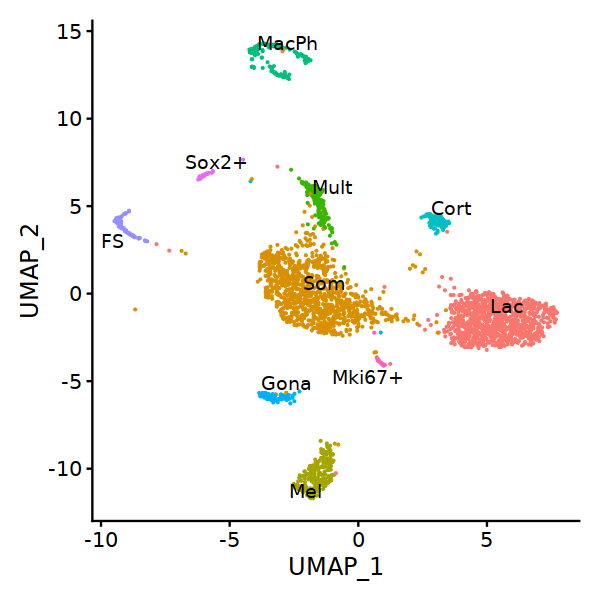

In [60]:
options(repr.plot.width=5,repr.plot.height=5)
DimPlot(object = mPit.10x.integrated, reduction = "umap", label = T,pt.size = .1,repel=T)  + theme(legend.position="none")

In [61]:
table(mPit.10x.integrated$sex,mPit.10x.integrated$res.name)

        
         Lac Som Mel Mult MacPh Cort Gona  FS Sox2+ Mki67+
  female 605 369 107   62    74   33   24  39    13     14
  male   337 668 125   89    55   57   52  35    18      4

### Plot marker genes here

In [79]:
genes.plot <- c("Pou1f1","Prl","Gh","Ghrhr","Tshb","Top2a","Mki67","Fshb","Lhb","Gnrhr","Pomc","Pax7","Tbx19","Crhr1",
                 "Sox2","Vim","Fstl1","Col1a1","Ctss")

DefaultAssay(mPit.10x.integrated) <- "RNA"
mPit.10x.integrated <- NormalizeData(mPit.10x.integrated)
mPit.10x.integrated <- ScaleData(mPit.10x.integrated)

unique(Idents(mPit.10x.integrated))

cluster.order <- c("Lac","Som","Mult","Mki67+","Gona","Mel","Cort","Sox2+","FS","MacPh")

mPit.10x.integrated@meta.data$res.name <- factor(mPit.10x.integrated@meta.data$res.name,levels=rev(cluster.order))

Idents(mPit.10x.integrated) <- "res.name"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



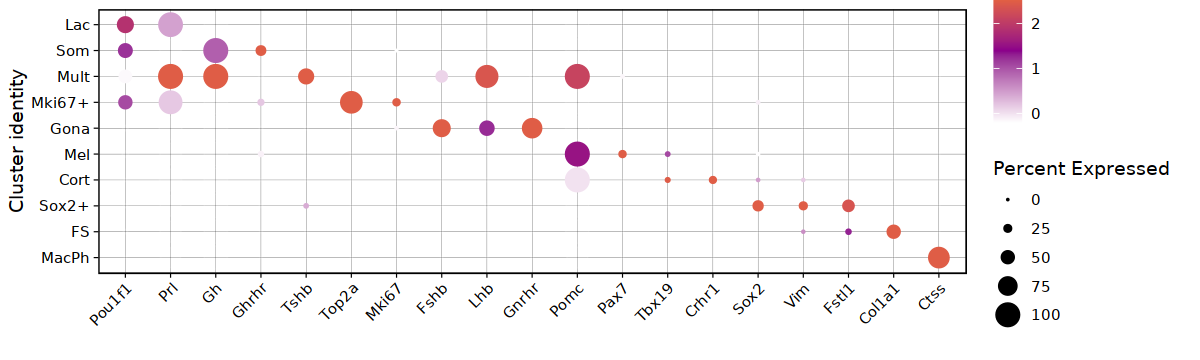

In [88]:
options(repr.plot.height=3,repr.plot.width=10)
DotPlot(mPit.10x.integrated, features = rev(genes.plot)) + RotatedAxis() + #coord_flip()+  
  scale_colour_gradientn(
      limits = c(-0.2,3), # here set -0.2 as a cutoff for visulization
  colours=c("white", "darkmagenta", "darkorange1"),na.value="#FFFFFF1a") +  ## values less than 0.001 will be transparent white (to reduce noise)
   theme_linedraw() + theme(axis.text.x = element_text(angle=45,hjust=1)) + xlab("") + ylab("Cluster identity")